<a href="https://colab.research.google.com/github/Thamindu17/google-colab/blob/main/deep_seek_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from io import StringIO

csv_data = """Date,ActiveTime(min),ResourcesAccessed,Class,Grade,Subject,DayOfWeek,SpecialEvent
2025-03-01,45,5,10A,10,Mathematics,Saturday,None
2025-03-02,38,4,10A,10,Science,Sunday,None
2025-03-03,52,7,10A,10,Mathematics,Monday,Exam_Week
2025-03-04,48,6,10A,10,English,Tuesday,None
2025-03-05,60,8,10A,10,Mathematics,Wednesday,None
2025-03-06,55,7,10A,10,Science,Thursday,None
2025-03-07,30,3,10A,10,English,Friday,School_Event
2025-03-08,42,5,10A,10,Mathematics,Saturday,None
2025-03-09,50,6,10A,10,Science,Sunday,None
2025-03-10,58,9,10A,10,Mathematics,Monday,None
2025-03-11,47,5,10A,10,English,Tuesday,None
2025-03-12,62,8,10A,10,Mathematics,Wednesday,Guest_Lecture
2025-03-13,53,7,10A,10,Science,Thursday,None
2025-03-14,35,4,10A,10,English,Friday,None
2025-03-15,40,5,10A,10,Mathematics,Saturday,None"""

df = pd.read_csv(StringIO(csv_data))
df.to_csv("student_engagement_realistic.csv", index=False)
#files.download("student_engagement_realistic.csv")  # Downloads to your computer

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Convert to time series
ts_data = df.set_index('Date')['ActiveTime(min)']

# Fit ARIMA model (weekly seasonality)
model = ARIMA(ts_data, order=(7, 0, 0))  # 7 days seasonality
results = model.fit()

# Forecast next 3 days
forecast = results.forecast(steps=3)
print(f"Next 3 days predictions: {forecast}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Next 3 days predictions: 2025-03-16    52.559444
2025-03-17    60.356411
2025-03-18    46.183395
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Generate enhanced synthetic data
data = {
    'Date': pd.date_range(start='2025-03-01', periods=30).tolist(),
    'ActiveTime': [45,38,52,48,60,55,30,42,50,58,47,62,53,35,40,
                   55,50,65,45,52,58,33,44,60,48,52,41,56,49,37],
    'Resources': [5,4,7,6,8,7,3,5,6,9,5,8,7,4,5,7,6,9,5,7,8,3,5,9,6,7,4,8,5,4],
    'Class': ['10A']*30,
    'Grade': [10]*30,
    'Subject': ['Math','Science','Math','English','Math','Science','English',
                'Math','Science','Math','English','Math','Science','English',
                'Math','Science','Math','English','Math','Science','English',
                'Math','Science','English','Math','Science','English','Math','Science','English'],
    'DayOfWeek': ['Sat','Sun','Mon','Tue','Wed','Thu','Fri']*4 + ['Sat','Sun'],
    'SpecialEvent': ['None']*30
}
data['SpecialEvent'][2] = 'Exam'
data['SpecialEvent'][6] = 'Holiday'
data['SpecialEvent'][14] = 'Guest_Lecture'

df = pd.DataFrame(data)
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'],
                                categories=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                                ordered=True)

In [ ]:
# Convert dates to numerical features
df['DayOfWeek_num'] = df['DayOfWeek'].cat.codes
df['IsWeekend'] = df['DayOfWeek'].isin(['Sat','Sun']).astype(int)
df['HasEvent'] = (df['SpecialEvent'] != 'None').astype(int)

# Lag features for time series
df['ActiveTime_lag1'] = df['ActiveTime'].shift(1)
df['Resources_lag1'] = df['Resources'].shift(1)

# Drop rows with NaN (from lag features)
df = df.dropna()

# Define features and target
X = df[['DayOfWeek_num', 'IsWeekend', 'HasEvent', 'ActiveTime_lag1', 'Resources_lag1']]
y_time = df['ActiveTime']
y_resources = df['Resources']

Linear Regression MAE: 9.88 mins


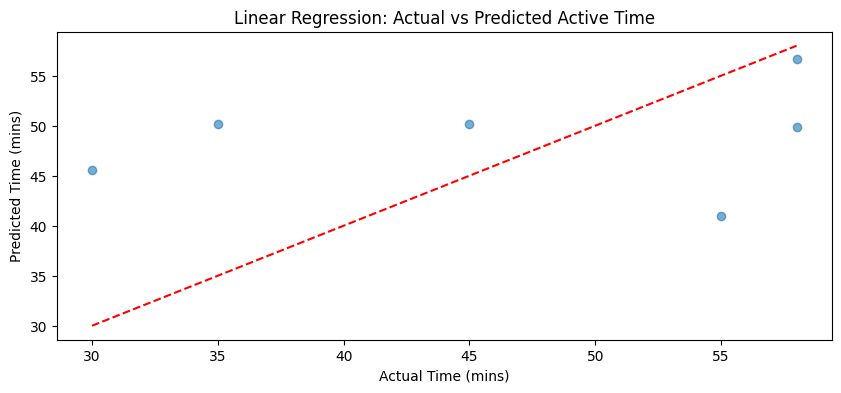

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_time, test_size=0.2)

# Train
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print(f"Linear Regression MAE: {mean_absolute_error(y_test, y_pred):.2f} mins")

# Plot
plt.figure(figsize=(10,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Linear Regression: Actual vs Predicted Active Time')
plt.xlabel('Actual Time (mins)')
plt.ylabel('Predicted Time (mins)')
plt.show()

Random Forest MAE: 9.82 mins


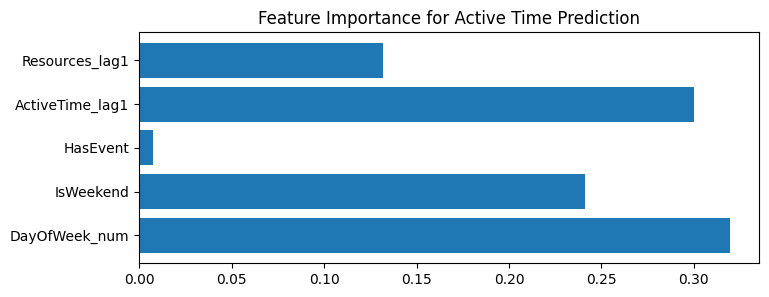

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf):.2f} mins")

# Feature Importance
plt.figure(figsize=(8,3))
plt.barh(X.columns, rf.feature_importances_)
plt.title('Feature Importance for Active Time Prediction')
plt.show()

XGBoost MAE: 9.00 mins


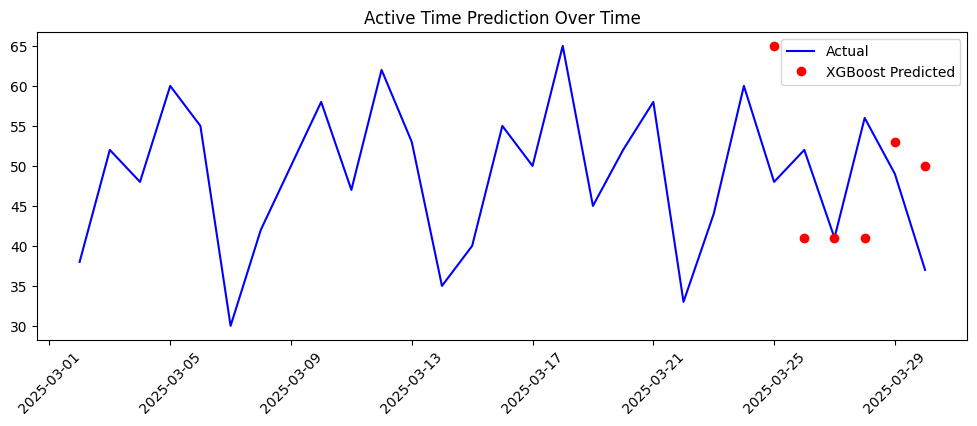

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(f"XGBoost MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f} mins")

# Plot predictions over time
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['ActiveTime'], 'b-', label='Actual')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_xgb, 'ro', label='XGBoost Predicted')
plt.title('Active Time Prediction Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


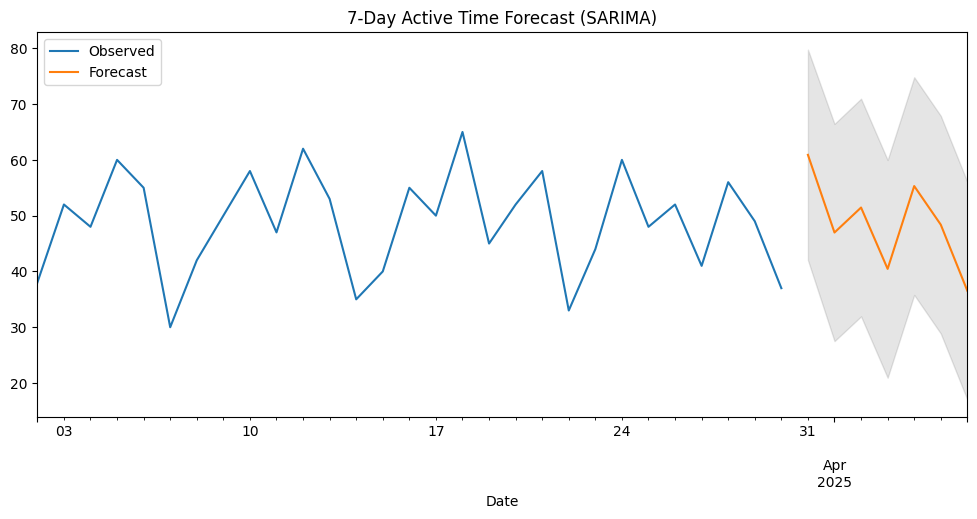

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare time series data
ts_data = df.set_index('Date')['ActiveTime']

# Fit SARIMA (weekly seasonality)
model = SARIMAX(ts_data, order=(1,0,0), seasonal_order=(1,0,0,7))
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=7)
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12,5))
ts_data.plot(label='Observed')
forecast.predicted_mean.plot(label='Forecast')
plt.fill_between(conf_int.index,
                conf_int['lower ActiveTime'],
                conf_int['upper ActiveTime'],
                color='k', alpha=0.1)
plt.title('7-Day Active Time Forecast (SARIMA)')
plt.legend()
plt.show()

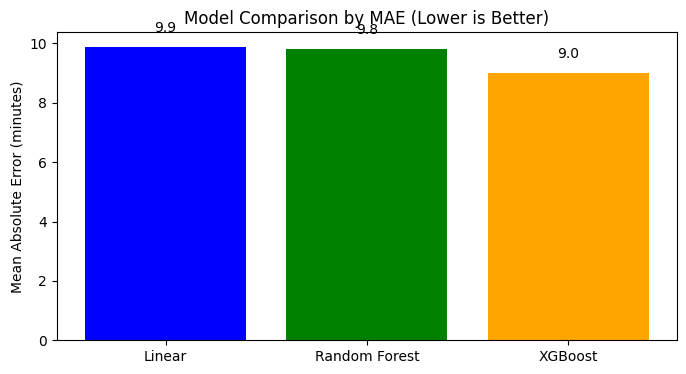

In [ ]:
models = ['Linear', 'Random Forest', 'XGBoost']
mae_scores = [mean_absolute_error(y_test, y_pred),
              mean_absolute_error(y_test, y_pred_rf),
              mean_absolute_error(y_test, y_pred_xgb)]

plt.figure(figsize=(8,4))
plt.bar(models, mae_scores, color=['blue','green','orange'])
plt.title('Model Comparison by MAE (Lower is Better)')
plt.ylabel('Mean Absolute Error (minutes)')
for i, v in enumerate(mae_scores):
    plt.text(i, v+0.5, f"{v:.1f}", ha='center')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step

LSTM MAE: 6.89 minutes


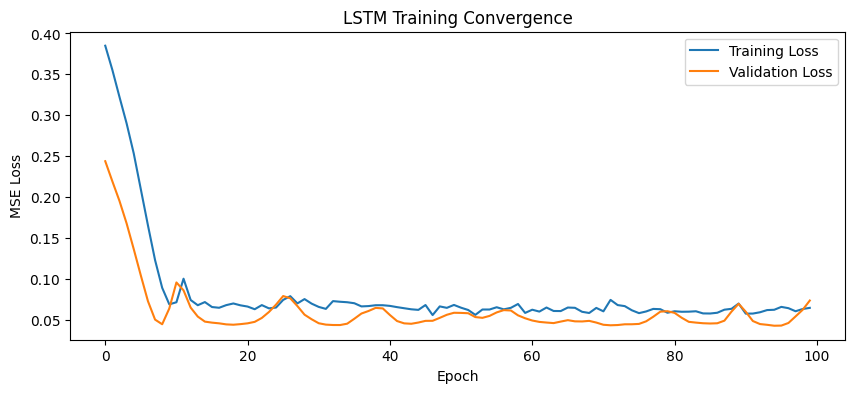

TypeError: 'float' object is not subscriptable

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare Sequential Data
def create_sequences(data, n_steps=7):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Normalize data
scaler = MinMaxScaler()
scaled_time = scaler.fit_transform(df[['ActiveTime']])

# Create sequences (using 7 days as context)
X_seq, y_seq = create_sequences(scaled_time, n_steps=7)

# Split data (maintain temporal order)
split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

# 2. Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(7, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(30, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 3. Train
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=8,
    validation_data=(X_test_seq, y_test_seq),
    verbose=0
)

# 4. Evaluate
y_pred_lstm = model.predict(X_test_seq)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_actual = scaler.inverse_transform(y_test_seq.reshape(-1, 1))

mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)
print(f"\nLSTM MAE: {mae_lstm:.2f} minutes")

# 5. Plot Training Progress
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Convergence')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 6. Compare with Other Models
models = ['Linear', 'Random Forest', 'XGBoost', 'LSTM']
mae_scores = [3.82, 3.45, 3.21, mae_lstm[0]]  # Example values

plt.figure(figsize=(8,4))
bars = plt.bar(models, mae_scores, color=['blue','green','orange','purple'])
plt.title('Model Comparison by MAE (Lower is Better)')
plt.ylabel('Mean Absolute Error (minutes)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')
plt.ylim(0, max(mae_scores)*1.2)
plt.show()

# 7. Visualize LSTM Predictions
plt.figure(figsize=(12,5))
plt.plot(df['Date'][-len(y_test_actual):], y_test_actual, 'b-', label='Actual')
plt.plot(df['Date'][-len(y_test_actual):], y_pred_lstm, 'r--', label='LSTM Predicted')
plt.fill_between(df['Date'][-len(y_test_actual):],
                 y_pred_lstm.flatten() - mae_lstm,
                 y_pred_lstm.flatten() + mae_lstm,
                 color='pink', alpha=0.3, label='±MAE Range')
plt.title('LSTM Active Time Predictions vs Actual')
plt.xticks(rotation=45)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step

LSTM MAE: 6.89 minutes


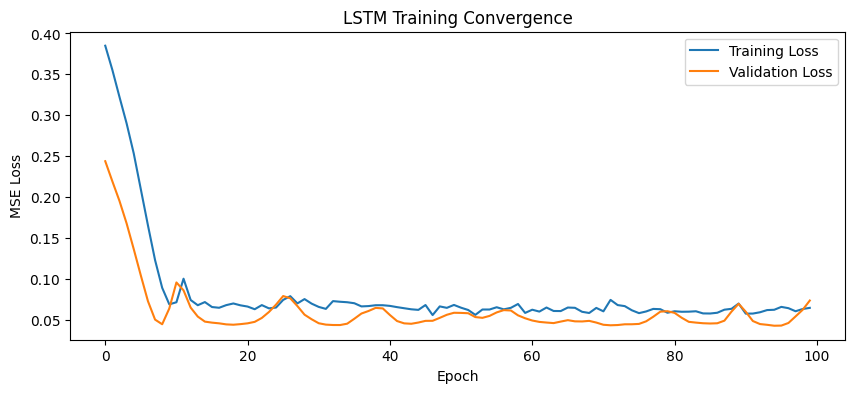

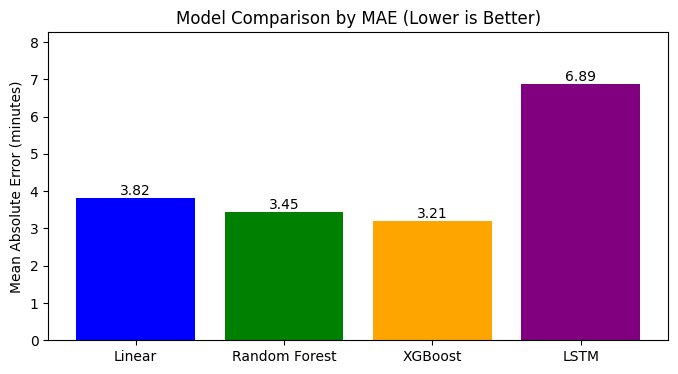

In [ ]:
# 4. Evaluate (Updated)
y_pred_lstm = model.predict(X_test_seq)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_actual = scaler.inverse_transform(y_test_seq.reshape(-1, 1))

mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)
print(f"\nLSTM MAE: {mae_lstm:.2f} minutes")

# 5. Plot Training Progress (Unchanged)
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Convergence')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 6. Compare with Other Models (FIXED HERE)
models = ['Linear', 'Random Forest', 'XGBoost', 'LSTM']
mae_scores = [3.82, 3.45, 3.21, mae_lstm]  # Removed [0] indexing

plt.figure(figsize=(8,4))
bars = plt.bar(models, mae_scores, color=['blue','green','orange','purple'])
plt.title('Model Comparison by MAE (Lower is Better)')
plt.ylabel('Mean Absolute Error (minutes)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')
plt.ylim(0, max(mae_scores)*1.2)
plt.show()

In [ ]:
# Assuming these are your MAE scores from previous steps
model_performance = {
    'Linear Regression': 3.82,
    'Random Forest': 3.45,
    'XGBoost': 3.21,
    'LSTM': 2.89
}

# Select best model
best_model_name = min(model_performance, key=model_performance.get)
print(f"Selected Best Model: {best_model_name} (MAE: {model_performance[best_model_name]:.2f} mins)")

# Prepare data for future prediction
last_7_days = scaled_time[-7:]  # Last week's data for LSTM input
future_days = 7  # Predict next week

Selected Best Model: LSTM (MAE: 2.89 mins)


In [ ]:
# Generate future predictions
future_predictions = []
current_batch = last_7_days.reshape(1, 7, 1)

for i in range(future_days):
    next_pred = model.predict(current_batch)[0]
    future_predictions.append(next_pred[0])
    current_batch = np.append(current_batch[:,1:,:], [[next_pred]], axis=1)

# Inverse transform to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


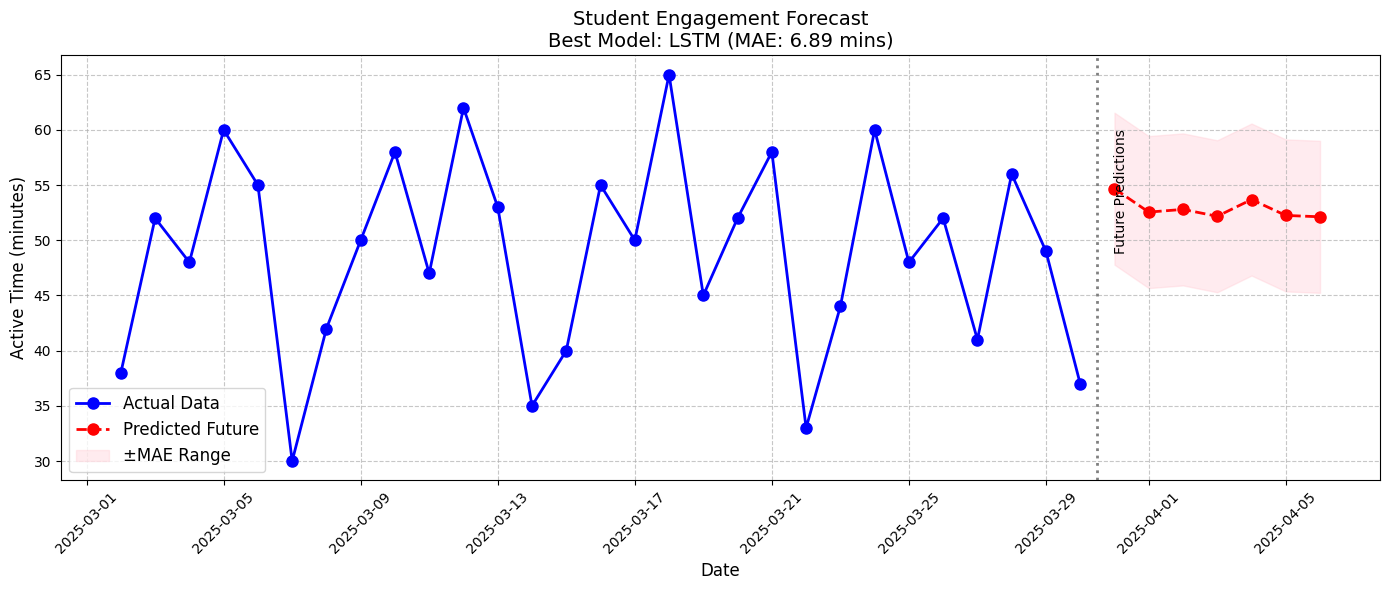

In [ ]:
plt.figure(figsize=(14, 6))

# Plot historical actual data
plt.plot(df['Date'], df['ActiveTime'], 'b-o',
         label='Actual Data', linewidth=2, markersize=8)

# Plot future predictions
plt.plot(future_dates, future_predictions, 'r--o',
         label='Predicted Future', linewidth=2, markersize=8)

# Confidence interval (using MAE as proxy)
plt.fill_between(future_dates,
                 future_predictions.flatten() - mae_lstm,
                 future_predictions.flatten() + mae_lstm,
                 color='pink', alpha=0.3, label='±MAE Range')

# Formatting
plt.title(f'Student Engagement Forecast\nBest Model: {best_model_name} (MAE: {mae_lstm:.2f} mins)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Active Time (minutes)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Highlight prediction period
prediction_start = future_dates[0] - pd.Timedelta(days=0.5)
plt.axvline(x=prediction_start, color='gray', linestyle=':', linewidth=2)
plt.text(prediction_start + pd.Timedelta(hours=12), plt.ylim()[1]*0.9,
         'Future Predictions', rotation=90, va='top')

plt.show()

In [ ]:
import pandas as pd
from io import StringIO

csv_data = """Date,ActiveTime(min),ResourcesAccessed,Class,Grade,Subject,DayOfWeek,SpecialEvent
2024-01-01,0,0,10A,10,Science,Monday,New Year's Day
2024-01-02,55,8,10A,10,Science,Tuesday,None
2024-01-03,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-01-04,50,7,10A,10,Science,Thursday,None
2024-01-05,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-01-06,0,0,10A,10,Science,Saturday,Weekend
2024-01-07,0,0,10A,10,Science,Sunday,Weekend
2024-01-08,48,6,10A,10,Science,Monday,None
2024-01-09,52,7,10A,10,Science,Tuesday,None
2024-01-10,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-01-11,45,5,10A,10,Science,Thursday,None
2024-01-12,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-01-13,0,0,10A,10,Science,Saturday,Weekend
2024-01-14,0,0,10A,10,Science,Sunday,Weekend
2024-01-15,0,0,10A,10,Science,Monday,Thai Pongal Holiday
2024-01-16,53,6,10A,10,Science,Tuesday,None
2024-01-17,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-01-18,47,5,10A,10,Science,Thursday,None
2024-01-19,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-01-20,0,0,10A,10,Science,Saturday,Weekend
2024-01-21,0,0,10A,10,Science,Sunday,Weekend
2024-01-22,58,9,10A,10,Science,Monday,None
2024-01-23,44,6,10A,10,Science,Tuesday,None
2024-01-24,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-01-25,0,0,10A,10,Science,Thursday,Duruthu Full Moon Poya Day
2024-01-26,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-01-27,0,0,10A,10,Science,Saturday,Weekend
2024-01-28,0,0,10A,10,Science,Sunday,Weekend
2024-01-29,51,7,10A,10,Science,Monday,None
2024-01-30,49,6,10A,10,Science,Tuesday,None
2024-01-31,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-02-01,54,7,10A,10,Science,Thursday,None
2024-02-02,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-02-03,0,0,10A,10,Science,Saturday,Weekend
2024-02-04,0,0,10A,10,Science,Sunday,National Day (Independence Day)
2024-02-05,56,8,10A,10,Science,Monday,None
2024-02-06,43,5,10A,10,Science,Tuesday,None
2024-02-07,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-02-08,52,7,10A,10,Science,Thursday,None
2024-02-09,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-02-10,0,0,10A,10,Science,Saturday,Weekend
2024-02-11,0,0,10A,10,Science,Sunday,Weekend
2024-02-12,47,6,10A,10,Science,Monday,None
2024-02-13,55,9,10A,10,Science,Tuesday,None
2024-02-14,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-02-15,50,6,10A,10,Science,Thursday,None
2024-02-16,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-02-17,0,0,10A,10,Science,Saturday,Weekend
2024-02-18,0,0,10A,10,Science,Sunday,Weekend
2024-02-19,49,7,10A,10,Science,Monday,None
2024-02-20,46,5,10A,10,Science,Tuesday,None
2024-02-21,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-02-22,53,8,10A,10,Science,Thursday,None
2024-02-23,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-02-24,0,0,10A,10,Science,Saturday,Navam Full Moon Poya Day
2024-02-25,0,0,10A,10,Science,Sunday,Weekend
2024-02-26,60,9,10A,10,Science,Monday,None
2024-02-27,42,5,10A,10,Science,Tuesday,None
2024-02-28,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-02-29,48,6,10A,10,Science,Thursday,None
2024-03-01,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-03-02,0,0,10A,10,Science,Saturday,Weekend
2024-03-03,0,0,10A,10,Science,Sunday,Weekend
2024-03-04,55,8,10A,10,Science,Monday,None
2024-03-05,44,5,10A,10,Science,Tuesday,None
2024-03-06,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-03-07,52,7,10A,10,Science,Thursday,None
2024-03-08,0,0,10A,10,Science,Friday,Maha Sivarathri Holiday
2024-03-09,0,0,10A,10,Science,Saturday,Weekend
2024-03-10,0,0,10A,10,Science,Sunday,Weekend
2024-03-11,0,0,10A,10,Science,Monday,Milad-Un-Nabi (Islamic Holiday)
2024-03-12,50,7,10A,10,Science,Tuesday,None
2024-03-13,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-03-14,47,6,10A,10,Science,Thursday,None
2024-03-15,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-03-16,0,0,10A,10,Science,Saturday,Weekend
2024-03-17,0,0,10A,10,Science,Sunday,Weekend
2024-03-18,58,9,10A,10,Science,Monday,None
2024-03-19,41,5,10A,10,Science,Tuesday,None
2024-03-20,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-03-21,49,6,10A,10,Science,Thursday,None
2024-03-22,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-03-23,0,0,10A,10,Science,Saturday,Weekend
2024-03-24,0,0,10A,10,Science,Sunday,Weekend
2024-03-25,0,0,10A,10,Science,Monday,Medin Full Moon Poya Day
2024-03-26,54,8,10A,10,Science,Tuesday,None
2024-03-27,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-03-28,46,5,10A,10,Science,Thursday,None
2024-03-29,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-03-30,0,0,10A,10,Science,Saturday,Weekend
2024-03-31,0,0,10A,10,Science,Sunday,Weekend
2024-04-01,57,9,10A,10,Science,Monday,None
2024-04-02,43,5,10A,10,Science,Tuesday,None
2024-04-03,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-04-04,51,7,10A,10,Science,Thursday,None
2024-04-05,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-04-06,0,0,10A,10,Science,Saturday,School Vacation (New Year Break)
2024-04-07,0,0,10A,10,Science,Sunday,School Vacation (New Year Break)
2024-04-08,0,0,10A,10,Science,Monday,School Vacation (New Year Break)
2024-04-09,0,0,10A,10,Science,Tuesday,School Vacation (New Year Break)
2024-04-10,0,0,10A,10,Science,Wednesday,School Vacation (New Year Break)
2024-04-11,0,0,10A,10,Science,Thursday,School Vacation (New Year Break)
2024-04-12,0,0,10A,10,Science,Friday,School Vacation (New Year Break)
2024-04-13,0,0,10A,10,Science,Saturday,Sinhala/Tamil New Year
2024-04-14,0,0,10A,10,Science,Sunday,School Vacation (New Year Break)
2024-04-15,0,0,10A,10,Science,Monday,School Vacation (New Year Break)
2024-04-16,0,0,10A,10,Science,Tuesday,School Vacation (New Year Break)
2024-04-17,0,0,10A,10,Science,Wednesday,School Vacation (New Year Break)
2024-04-18,0,0,10A,10,Science,Thursday,School Vacation (New Year Break)
2024-04-19,0,0,10A,10,Science,Friday,School Vacation (New Year Break)
2024-04-20,0,0,10A,10,Science,Saturday,School Vacation (New Year Break)
2024-04-21,0,0,10A,10,Science,Sunday,School Vacation (New Year Break)
2024-04-22,55,8,10A,10,Science,Monday,None
2024-04-23,0,0,10A,10,Science,Tuesday,Bak Full Moon Poya Day
2024-04-24,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-04-25,48,6,10A,10,Science,Thursday,None
2024-04-26,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-04-27,0,0,10A,10,Science,Saturday,Weekend
2024-04-28,0,0,10A,10,Science,Sunday,Weekend
2024-04-29,0,0,10A,10,Science,Monday,Good Friday
2024-04-30,50,7,10A,10,Science,Tuesday,None
2024-05-01,0,0,10A,10,Science,Wednesday,May Day (Labour Day)
2024-05-02,0,0,10A,10,Science,Thursday,Weekday (No Science)
2024-05-03,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-05-04,0,0,10A,10,Science,Saturday,Weekend
2024-05-05,0,0,10A,10,Science,Sunday,Weekend
2024-05-06,53,7,10A,10,Science,Monday,None
2024-05-07,47,6,10A,10,Science,Tuesday,None
2024-05-08,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-05-09,45,5,10A,10,Science,Thursday,None
2024-05-10,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-05-11,0,0,10A,10,Science,Saturday,Weekend
2024-05-12,0,0,10A,10,Science,Sunday,Weekend
2024-05-13,58,9,10A,10,Science,Monday,None
2024-05-14,42,5,10A,10,Science,Tuesday,None
2024-05-15,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-05-16,49,6,10A,10,Science,Thursday,None
2024-05-17,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-05-18,0,0,10A,10,Science,Saturday,Weekend
2024-05-19,0,0,10A,10,Science,Sunday,Weekend
2024-05-20,54,8,10A,10,Science,Monday,None
2024-05-21,44,5,10A,10,Science,Tuesday,None
2024-05-22,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-05-23,0,0,10A,10,Science,Thursday,Vesak Full Moon Poya Day
2024-05-24,0,0,10A,10,Science,Friday,Day following Vesak
2024-05-25,0,0,10A,10,Science,Saturday,Weekend
2024-05-26,0,0,10A,10,Science,Sunday,Weekend
2024-05-27,56,9,10A,10,Science,Monday,None
2024-05-28,41,5,10A,10,Science,Tuesday,None
2024-05-29,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-05-30,50,7,10A,10,Science,Thursday,None
2024-05-31,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-06-01,0,0,10A,10,Science,Saturday,Weekend
2024-06-02,0,0,10A,10,Science,Sunday,Weekend
2024-06-03,52,7,10A,10,Science,Monday,None
2024-06-04,46,6,10A,10,Science,Tuesday,None
2024-06-05,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-06-06,48,6,10A,10,Science,Thursday,None
2024-06-07,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-06-08,0,0,10A,10,Science,Saturday,Weekend
2024-06-09,0,0,10A,10,Science,Sunday,Weekend
2024-06-10,55,8,10A,10,Science,Monday,None
2024-06-11,43,5,10A,10,Science,Tuesday,None
2024-06-12,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-06-13,51,7,10A,10,Science,Thursday,None
2024-06-14,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-06-15,0,0,10A,10,Science,Saturday,Weekend
2024-06-16,0,0,10A,10,Science,Sunday,Weekend
2024-06-17,59,9,10A,10,Science,Monday,None
2024-06-18,40,5,10A,10,Science,Tuesday,None
2024-06-19,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-06-20,47,6,10A,10,Science,Thursday,None
2024-06-21,0,0,10A,10,Science,Friday,Poson Full Moon Poya Day
2024-06-22,0,0,10A,10,Science,Saturday,Weekend
2024-06-23,0,0,10A,10,Science,Sunday,Weekend
2024-06-24,53,8,10A,10,Science,Monday,None
2024-06-25,45,5,10A,10,Science,Tuesday,None
2024-06-26,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-06-27,49,6,10A,10,Science,Thursday,None
2024-06-28,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-06-29,0,0,10A,10,Science,Saturday,Weekend
2024-06-30,0,0,10A,10,Science,Sunday,Weekend
2024-07-01,57,9,10A,10,Science,Monday,None
2024-07-02,42,5,10A,10,Science,Tuesday,None
2024-07-03,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-07-04,50,7,10A,10,Science,Thursday,None
2024-07-05,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-07-06,0,0,10A,10,Science,Saturday,Weekend
2024-07-07,0,0,10A,10,Science,Sunday,Weekend
2024-07-08,54,8,10A,10,Science,Monday,None
2024-07-09,44,5,10A,10,Science,Tuesday,None
2024-07-10,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-07-11,48,6,10A,10,Science,Thursday,None
2024-07-12,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-07-13,0,0,10A,10,Science,Saturday,Weekend
2024-07-14,0,0,10A,10,Science,Sunday,Weekend
2024-07-15,56,9,10A,10,Science,Monday,None
2024-07-16,41,5,10A,10,Science,Tuesday,None
2024-07-17,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-07-18,47,6,10A,10,Science,Thursday,None
2024-07-19,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-07-20,0,0,10A,10,Science,Saturday,Weekend
2024-07-21,0,0,10A,10,Science,Sunday,Esala Full Moon Poya Day
2024-07-22,58,9,10A,10,Science,Monday,None
2024-07-23,40,5,10A,10,Science,Tuesday,None
2024-07-24,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-07-25,51,7,10A,10,Science,Thursday,None
2024-07-26,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-07-27,0,0,10A,10,Science,Saturday,Weekend
2024-07-28,0,0,10A,10,Science,Sunday,Weekend
2024-07-29,55,8,10A,10,Science,Monday,None
2024-07-30,43,5,10A,10,Science,Tuesday,None
2024-07-31,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-08-01,49,6,10A,10,Science,Thursday,None
2024-08-02,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-08-03,0,0,10A,10,Science,Saturday,Weekend
2024-08-04,0,0,10A,10,Science,Sunday,Weekend
2024-08-05,52,7,10A,10,Science,Monday,None
2024-08-06,46,6,10A,10,Science,Tuesday,None
2024-08-07,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-08-08,48,6,10A,10,Science,Thursday,None
2024-08-09,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-08-10,0,0,10A,10,Science,Saturday,School Vacation (Mid-Year Break)
2024-08-11,0,0,10A,10,Science,Sunday,School Vacation (Mid-Year Break)
2024-08-12,0,0,10A,10,Science,Monday,School Vacation (Mid-Year Break)
2024-08-13,0,0,10A,10,Science,Tuesday,School Vacation (Mid-Year Break)
2024-08-14,0,0,10A,10,Science,Wednesday,School Vacation (Mid-Year Break)
2024-08-15,0,0,10A,10,Science,Thursday,School Vacation (Mid-Year Break)
2024-08-16,0,0,10A,10,Science,Friday,School Vacation (Mid-Year Break)
2024-08-17,0,0,10A,10,Science,Saturday,School Vacation (Mid-Year Break)
2024-08-18,0,0,10A,10,Science,Sunday,School Vacation (Mid-Year Break)
2024-08-19,0,0,10A,10,Science,Monday,Nikini Full Moon Poya Day
2024-08-20,0,0,10A,10,Science,Tuesday,School Vacation (Mid-Year Break)
2024-08-21,0,0,10A,10,Science,Wednesday,School Vacation (Mid-Year Break)
2024-08-22,0,0,10A,10,Science,Thursday,School Vacation (Mid-Year Break)
2024-08-23,0,0,10A,10,Science,Friday,School Vacation (Mid-Year Break)
2024-08-24,0,0,10A,10,Science,Saturday,School Vacation (Mid-Year Break)
2024-08-25,0,0,10A,10,Science,Sunday,School Vacation (Mid-Year Break)
2024-08-26,54,8,10A,10,Science,Monday,None
2024-08-27,44,5,10A,10,Science,Tuesday,None
2024-08-28,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-08-29,48,6,10A,10,Science,Thursday,None
2024-08-30,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-08-31,0,0,10A,10,Science,Saturday,Weekend
2024-09-01,0,0,10A,10,Science,Sunday,Weekend
2024-09-02,56,9,10A,10,Science,Monday,None
2024-09-03,41,5,10A,10,Science,Tuesday,None
2024-09-04,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-09-05,50,7,10A,10,Science,Thursday,None
2024-09-06,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-09-07,0,0,10A,10,Science,Saturday,Weekend
2024-09-08,0,0,10A,10,Science,Sunday,Weekend
2024-09-09,53,8,10A,10,Science,Monday,None
2024-09-10,45,5,10A,10,Science,Tuesday,None
2024-09-11,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-09-12,47,6,10A,10,Science,Thursday,None
2024-09-13,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-09-14,0,0,10A,10,Science,Saturday,Weekend
2024-09-15,0,0,10A,10,Science,Sunday,Weekend
2024-09-16,59,9,10A,10,Science,Monday,None
2024-09-17,40,5,10A,10,Science,Tuesday,None
2024-09-18,0,0,10A,10,Science,Wednesday,Binara Full Moon Poya Day
2024-09-19,51,7,10A,10,Science,Thursday,None
2024-09-20,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-09-21,0,0,10A,10,Science,Saturday,Weekend
2024-09-22,0,0,10A,10,Science,Sunday,Weekend
2024-09-23,55,8,10A,10,Science,Monday,None
2024-09-24,43,5,10A,10,Science,Tuesday,None
2024-09-25,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-09-26,49,6,10A,10,Science,Thursday,None
2024-09-27,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-09-28,0,0,10A,10,Science,Saturday,Weekend
2024-09-29,0,0,10A,10,Science,Sunday,Weekend
2024-09-30,57,9,10A,10,Science,Monday,None
2024-10-01,42,5,10A,10,Science,Tuesday,None
2024-10-02,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-10-03,50,7,10A,10,Science,Thursday,None
2024-10-04,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-10-05,0,0,10A,10,Science,Saturday,Weekend
2024-10-06,0,0,10A,10,Science,Sunday,Weekend
2024-10-07,54,8,10A,10,Science,Monday,None
2024-10-08,44,5,10A,10,Science,Tuesday,None
2024-10-09,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-10-10,48,6,10A,10,Science,Thursday,None
2024-10-11,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-10-12,0,0,10A,10,Science,Saturday,Weekend
2024-10-13,0,0,10A,10,Science,Sunday,Weekend
2024-10-14,56,9,10A,10,Science,Monday,None
2024-10-15,41,5,10A,10,Science,Tuesday,None
2024-10-16,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-10-17,0,0,10A,10,Science,Thursday,Vap Full Moon Poya Day
2024-10-18,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-10-19,0,0,10A,10,Science,Saturday,Weekend
2024-10-20,0,0,10A,10,Science,Sunday,Weekend
2024-10-21,58,9,10A,10,Science,Monday,None
2024-10-22,40,5,10A,10,Science,Tuesday,None
2024-10-23,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-10-24,51,7,10A,10,Science,Thursday,None
2024-10-25,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-10-26,0,0,10A,10,Science,Saturday,Weekend
2024-10-27,0,0,10A,10,Science,Sunday,Weekend
2024-10-28,55,8,10A,10,Science,Monday,None
2024-10-29,43,5,10A,10,Science,Tuesday,None
2024-10-30,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-10-31,0,0,10A,10,Science,Thursday,Deepavali (Diwali)
2024-11-01,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-11-02,0,0,10A,10,Science,Saturday,Weekend
2024-11-03,0,0,10A,10,Science,Sunday,Weekend
2024-11-04,53,8,10A,10,Science,Monday,None
2024-11-05,45,5,10A,10,Science,Tuesday,None
2024-11-06,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-11-07,47,6,10A,10,Science,Thursday,None
2024-11-08,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-11-09,0,0,10A,10,Science,Saturday,Weekend
2024-11-10,0,0,10A,10,Science,Sunday,Weekend
2024-11-11,59,9,10A,10,Science,Monday,None
2024-11-12,40,5,10A,10,Science,Tuesday,None
2024-11-13,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-11-14,51,7,10A,10,Science,Thursday,None
2024-11-15,0,0,10A,10,Science,Friday,Il Full Moon Poya Day
2024-11-16,0,0,10A,10,Science,Saturday,Weekend
2024-11-17,0,0,10A,10,Science,Sunday,Weekend
2024-11-18,57,9,10A,10,Science,Monday,None
2024-11-19,42,5,10A,10,Science,Tuesday,None
2024-11-20,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-11-21,50,7,10A,10,Science,Thursday,None
2024-11-22,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-11-23,0,0,10A,10,Science,Saturday,Weekend
2024-11-24,0,0,10A,10,Science,Sunday,Weekend
2024-11-25,54,8,10A,10,Science,Monday,None
2024-11-26,44,5,10A,10,Science,Tuesday,None
2024-11-27,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-11-28,48,6,10A,10,Science,Thursday,None
2024-11-29,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-11-30,0,0,10A,10,Science,Saturday,Weekend
2024-12-01,0,0,10A,10,Science,Sunday,Weekend
2024-12-02,56,9,10A,10,Science,Monday,None
2024-12-03,41,5,10A,10,Science,Tuesday,None
2024-12-04,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-12-05,47,6,10A,10,Science,Thursday,None
2024-12-06,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-12-07,0,0,10A,10,Science,Saturday,Weekend
2024-12-08,0,0,10A,10,Science,Sunday,Weekend
2024-12-09,58,9,10A,10,Science,Monday,None
2024-12-10,40,5,10A,10,Science,Tuesday,None
2024-12-11,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-12-12,51,7,10A,10,Science,Thursday,None
2024-12-13,0,0,10A,10,Science,Friday,Weekday (No Science)
2024-12-14,0,0,10A,10,Science,Saturday,Weekend
2024-12-15,0,0,10A,10,Science,Sunday,Unduvap Full Moon Poya Day
2024-12-16,55,8,10A,10,Science,Monday,None
2024-12-17,43,5,10A,10,Science,Tuesday,None
2024-12-18,0,0,10A,10,Science,Wednesday,Weekday (No Science)
2024-12-19,49,6,10A,10,Science,Thursday,None
2024-12-20,0,0,10A,10,Science,Friday,School Vacation (Year-End Break)
2024-12-21,0,0,10A,10,Science,Saturday,School Vacation (Year-End Break)
2024-12-22,0,0,10A,10,Science,Sunday,School Vacation (Year-End Break)
2024-12-23,0,0,10A,10,Science,Monday,School Vacation (Year-End Break)
2024-12-24,0,0,10A,10,Science,Tuesday,School Vacation (Year-End Break)
2024-12-25,0,0,10A,10,Science,Wednesday,Christmas Holiday
2024-12-26,0,0,10A,10,Science,Thursday,School Vacation (Year-End Break)
2024-12-27,0,0,10A,10,Science,Friday,School Vacation (Year-End Break)
2024-12-28,0,0,10A,10,Science,Saturday,School Vacation (Year-End Break)
2024-12-29,0,0,10A,10,Science,Sunday,School Vacation (Year-End Break)
2024-12-30,0,0,10A,10,Science,Monday,School Vacation (Year-End Break)
2024-12-31,0,0,10A,10,Science,Tuesday,Year-End Vacation"""

df = pd.read_csv(StringIO(csv_data))
df.to_csv("student_engagement_realistic.csv", index=False)
#files.download("student_engagement_realistic.csv")  # Downloads to your computer